In [33]:
import pandas as pd
import numpy as np

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

In [34]:
df = pd.read_csv('data/data/daily_min_temp.csv', parse_dates=['Date'], index_col='Date')
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [35]:
df = df.resample('W').mean()

<Axes: xlabel='Date'>

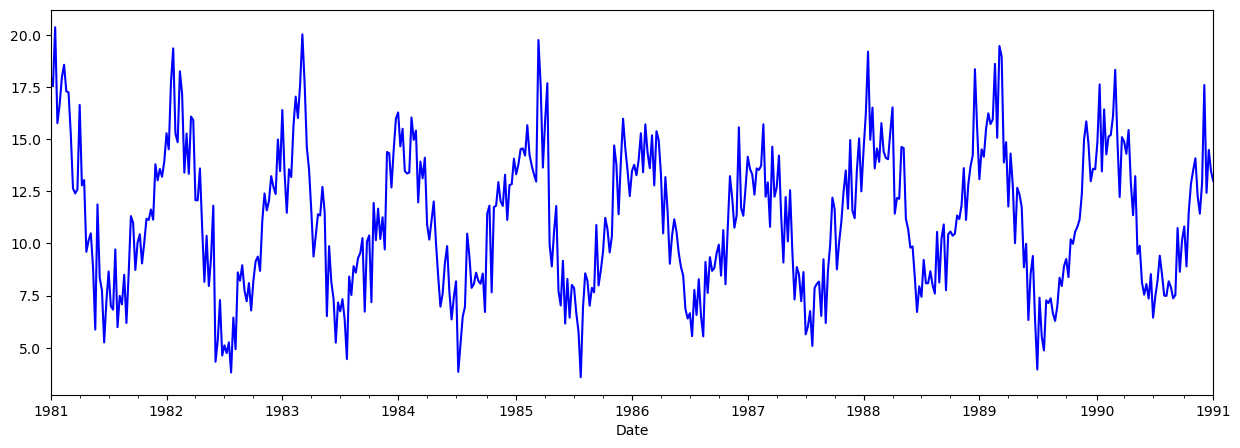

In [36]:
df.Temp.plot(figsize=(15, 5), color='b')

# Dataset Splitting

In [37]:
from sklearn.model_selection import train_test_split

ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((418, 1), (105, 1))

# Dataset & Dataloader

In [38]:
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

bs = 8
seq_len = 16

train_set = TimeSeriesDataset(ts_train, 'Temp', seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, 'Temp', seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (26, 16, 1)
Note: last 1 data excluded

(N, S, F): (6, 16, 1)
Note: last 8 data excluded



# Arsitektur & Config

In [39]:
from jcopdl.layers import linear_block

class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)

        return x, hidden

In [40]:
train_set.n_feature

1

In [41]:
config = set_config({
    'input_size': train_set.n_feature,
    'output_size': 1,
    'hidden_size': 64, 
    'num_layers': 2,
    'dropout': 0,
    'seq_len': train_set.n_seq
})

# Training Preparatioon -> MCOC

In [42]:
model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr = 0.001)
callback = Callback(model, config, outdir='model/rnn')

# Training

In [43]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode =="train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0

    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]

    cost = cost / len(dataset)

    return cost

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 129.3480 | Test_cost  = 119.9892 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 109.3267 | Test_cost  = 101.9042 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 92.5141 | Test_cost  = 86.8784 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 78.6811 | Test_cost  = 75.0788 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 68.0627 | Test_cost  = 66.4708 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 60.3636 | Test_cost  = 60.1773 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 54.6682 | Test_cost  = 55.2883 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 50.1579 | Test_cost  = 51.1923 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 46.3229 | Test_cost  = 47.5777 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 42.9162 | Test_cost  = 44.3088 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 39.8303 | Test_cost  = 41.3244 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 37.0147 | Test_cost  = 38.5914 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 34.4406 | Test_cost  = 36.0882 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 32.0878 | Test_cost  = 33.7973 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 29.9398 | Test_cost  = 31.7038 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 27.9818 | Test_cost  = 29.7936 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 26.2002 | Test_cost  = 28.0536 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 24.5820 | Test_cost  = 26.4715 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 23.1153 | Test_cost  = 25.0356 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 21.7884 | Test_cost  = 23.7348 | 


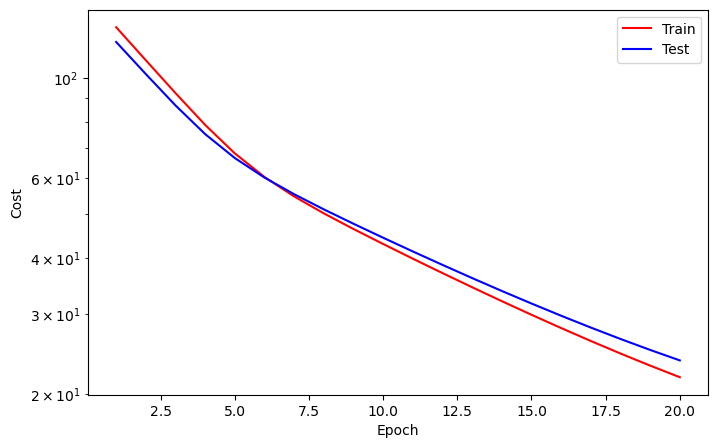

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 20.5906 | Test_cost  = 22.5587 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 19.5118 | Test_cost  = 21.4974 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 18.5422 | Test_cost  = 20.5417 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 17.6729 | Test_cost  = 19.6828 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 16.8953 | Test_cost  = 18.9125 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 16.2013 | Test_cost  = 18.2232 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 15.5836 | Test_cost  = 17.6076 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 15.0351 | Test_cost  = 17.0589 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 14.5492 | Test_cost  = 16.5710 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 14.1200 | Test_cost  = 16.1380 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 13.7417 | Test_cost  = 15.7544 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 13.4091 | Test_cost  = 15.4153 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 13.1175 | Test_cost  = 15.1161 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 12.8624 | Test_cost  = 14.8526 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 12.6398 | Test_cost  = 14.6210 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 12.4460 | Test_cost  = 14.4177 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 12.2777 | Test_cost  = 14.2395 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 12.1319 | Test_cost  = 14.0835 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 12.0058 | Test_cost  = 13.9473 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 11.8970 | Test_cost  = 13.8283 | 


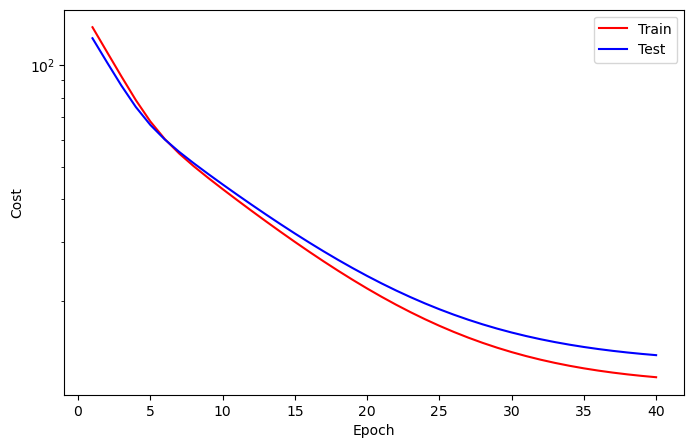

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 11.8033 | Test_cost  = 13.7245 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 11.7227 | Test_cost  = 13.6341 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 11.6536 | Test_cost  = 13.5554 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 11.5944 | Test_cost  = 13.4870 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 11.5437 | Test_cost  = 13.4274 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 11.5004 | Test_cost  = 13.3756 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 11.4635 | Test_cost  = 13.3305 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 11.4319 | Test_cost  = 13.2913 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 11.4050 | Test_cost  = 13.2573 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 11.3821 | Test_cost  = 13.2276 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 11.3626 | Test_cost  = 13.2018 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 11.3459 | Test_cost  = 13.1793 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 11.3317 | Test_cost  = 13.1596 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 11.3195 | Test_cost  = 13.1425 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 11.3091 | Test_cost  = 13.1276 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 11.3002 | Test_cost  = 13.1145 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 11.2926 | Test_cost  = 13.1030 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 11.2860 | Test_cost  = 13.0930 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 11.2803 | Test_cost  = 13.0841 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 11.2754 | Test_cost  = 13.0764 | 


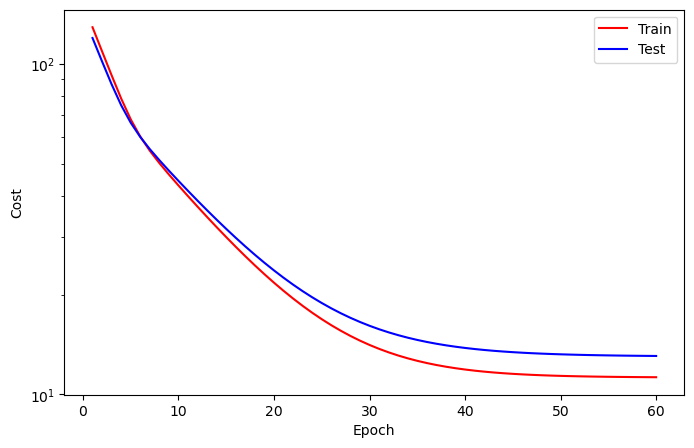

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 11.2712 | Test_cost  = 13.0696 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 11.2674 | Test_cost  = 13.0635 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 11.2642 | Test_cost  = 13.0582 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 11.2613 | Test_cost  = 13.0535 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 11.2588 | Test_cost  = 13.0494 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 11.2566 | Test_cost  = 13.0457 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 11.2546 | Test_cost  = 13.0424 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 11.2528 | Test_cost  = 13.0394 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 11.2512 | Test_cost  = 13.0368 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 11.2497 | Test_cost  = 13.0344 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 11.2484 | Test_cost  = 13.0323 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 11.2471 | Test_cost  = 13.0303 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 11.2460 | Test_cost  = 13.0286 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 11.2449 | Test_cost  = 13.0269 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 11.2439 | Test_cost  = 13.0255 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 11.2429 | Test_cost  = 13.0241 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 11.2420 | Test_cost  = 13.0228 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 11.2411 | Test_cost  = 13.0216 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 11.2403 | Test_cost  = 13.0204 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 11.2394 | Test_cost  = 13.0193 | 


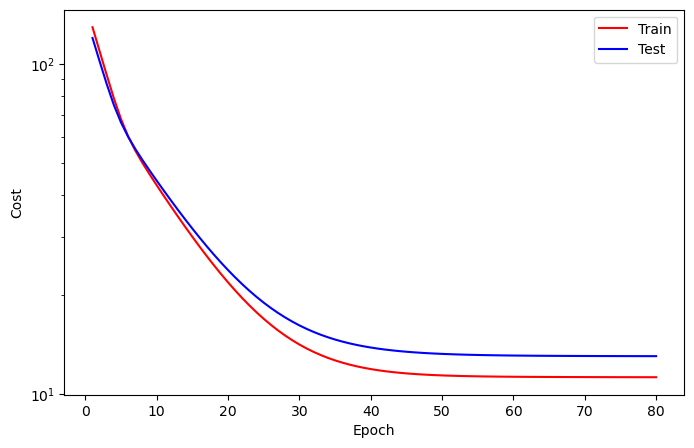

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 11.2386 | Test_cost  = 13.0182 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 11.2378 | Test_cost  = 13.0172 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 11.2369 | Test_cost  = 13.0162 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 11.2361 | Test_cost  = 13.0152 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 11.2353 | Test_cost  = 13.0142 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 11.2344 | Test_cost  = 13.0132 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 11.2336 | Test_cost  = 13.0122 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 11.2327 | Test_cost  = 13.0112 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 11.2318 | Test_cost  = 13.0102 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 11.2308 | Test_cost  = 13.0091 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 11.2299 | Test_cost  = 13.0080 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 11.2289 | Test_cost  = 13.0069 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 11.2278 | Test_cost  = 13.0057 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 11.2268 | Test_cost  = 13.0044 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 11.2256 | Test_cost  = 13.0031 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 11.2244 | Test_cost  = 13.0017 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 11.2231 | Test_cost  = 13.0003 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 11.2218 | Test_cost  = 12.9987 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 11.2203 | Test_cost  = 12.9970 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 11.2188 | Test_cost  = 12.9952 | 


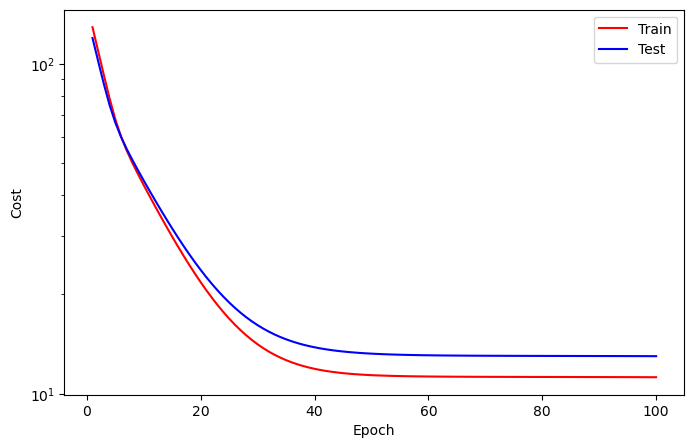

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 11.2171 | Test_cost  = 12.9932 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 11.2152 | Test_cost  = 12.9910 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 11.2131 | Test_cost  = 12.9885 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 11.2108 | Test_cost  = 12.9856 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 11.2080 | Test_cost  = 12.9823 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 11.2048 | Test_cost  = 12.9781 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 11.2007 | Test_cost  = 12.9726 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 11.1951 | Test_cost  = 12.9647 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 11.1868 | Test_cost  = 12.9521 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 11.1731 | Test_cost  = 12.9301 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 11.1487 | Test_cost  = 12.8967 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 11.1150 | Test_cost  = 12.8753 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 11.0940 | Test_cost  = 12.8668 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 11.0784 | Test_cost  = 12.8209 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 11.0370 | Test_cost  = 12.7452 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 10.9826 | Test_cost  = 12.6783 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 10.9332 | Test_cost  = 12.6119 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 10.8815 | Test_cost  = 12.5471 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 10.8292 | Test_cost  = 12.4638 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 10.7513 | Test_cost  = 12.3129 | 


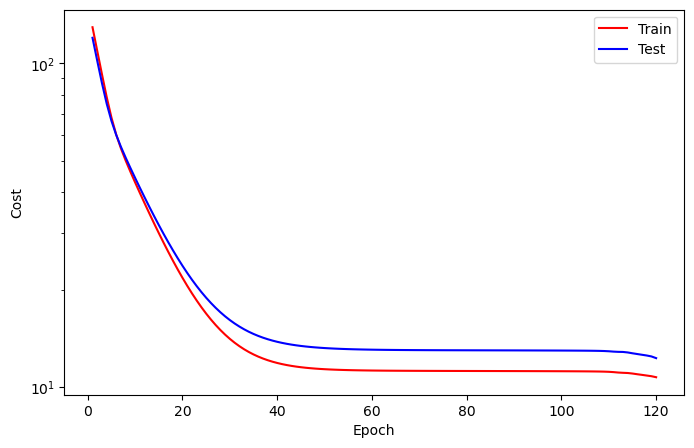

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 10.6004 | Test_cost  = 12.0602 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 10.4157 | Test_cost  = 11.9139 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 10.2518 | Test_cost  = 11.5964 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 9.9409 | Test_cost  = 11.0857 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 9.5321 | Test_cost  = 10.7096 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 9.1193 | Test_cost  = 10.0949 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 8.5102 | Test_cost  = 9.5040 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 8.0654 | Test_cost  = 9.0394 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 7.8029 | Test_cost  = 8.6286 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 7.4542 | Test_cost  = 8.2267 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 7.2251 | Test_cost  = 7.8815 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 6.9513 | Test_cost  = 7.6487 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 6.7886 | Test_cost  = 7.3785 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 6.5580 | Test_cost  = 7.1634 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 6.4278 | Test_cost  = 6.9405 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 6.2515 | Test_cost  = 6.7468 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 6.1239 | Test_cost  = 6.5672 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 6.0002 | Test_cost  = 6.4014 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 5.8766 | Test_cost  = 6.2539 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 5.7838 | Test_cost  = 6.1089 | 


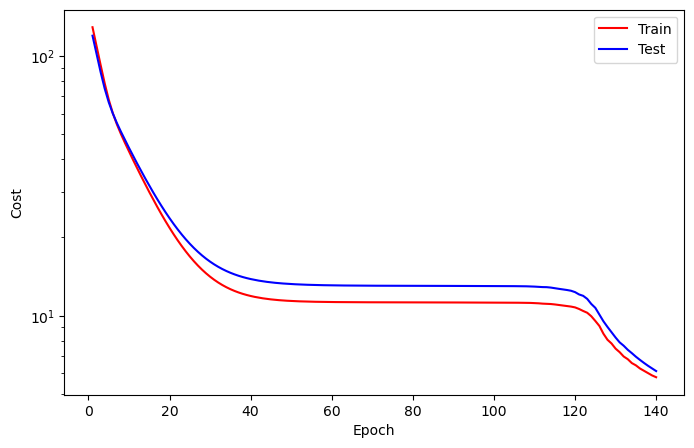

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 5.6684 | Test_cost  = 5.9827 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 5.5854 | Test_cost  = 5.8540 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 5.4803 | Test_cost  = 5.7399 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 5.3989 | Test_cost  = 5.6230 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 5.3007 | Test_cost  = 5.5168 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 5.2164 | Test_cost  = 5.4088 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 5.1206 | Test_cost  = 5.3068 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 5.0327 | Test_cost  = 5.2034 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 4.9390 | Test_cost  = 5.1031 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 4.8511 | Test_cost  = 5.0032 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 4.7628 | Test_cost  = 4.9063 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 4.6789 | Test_cost  = 4.8123 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 4.5981 | Test_cost  = 4.7207 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 4.5192 | Test_cost  = 4.6332 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 4.4451 | Test_cost  = 4.5473 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   156
Train_cost  = 4.3712 | Test_cost  = 4.4687 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   157
Train_cost  = 4.3042 | Test_cost  = 4.3945 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 4.2384 | Test_cost  = 4.3310 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   159
Train_cost  = 4.1783 | Test_cost  = 4.2759 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   160
Train_cost  = 4.1214 | Test_cost  = 4.2258 | 


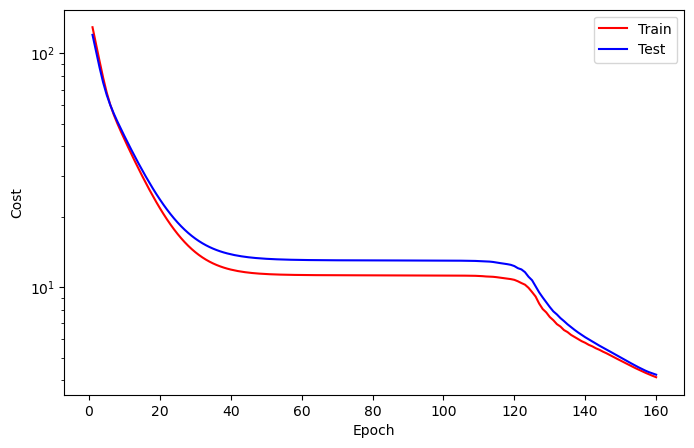

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   161
Train_cost  = 4.0667 | Test_cost  = 4.1821 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   162
Train_cost  = 4.0169 | Test_cost  = 4.1404 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   163
Train_cost  = 3.9707 | Test_cost  = 4.1005 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 3.9285 | Test_cost  = 4.0628 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 3.8913 | Test_cost  = 4.0237 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   166
Train_cost  = 3.8572 | Test_cost  = 3.9834 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 3.8253 | Test_cost  = 3.9439 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 3.7959 | Test_cost  = 3.9045 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 3.7686 | Test_cost  = 3.8649 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   170
Train_cost  = 3.7430 | Test_cost  = 3.8267 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   171
Train_cost  = 3.7191 | Test_cost  = 3.7901 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   172
Train_cost  = 3.6966 | Test_cost  = 3.7544 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   173
Train_cost  = 3.6753 | Test_cost  = 3.7207 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   174
Train_cost  = 3.6554 | Test_cost  = 3.6892 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   175
Train_cost  = 3.6367 | Test_cost  = 3.6588 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   176
Train_cost  = 3.6187 | Test_cost  = 3.6296 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   177
Train_cost  = 3.6016 | Test_cost  = 3.6019 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   178
Train_cost  = 3.5854 | Test_cost  = 3.5751 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   179
Train_cost  = 3.5696 | Test_cost  = 3.5491 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   180
Train_cost  = 3.5543 | Test_cost  = 3.5241 | 


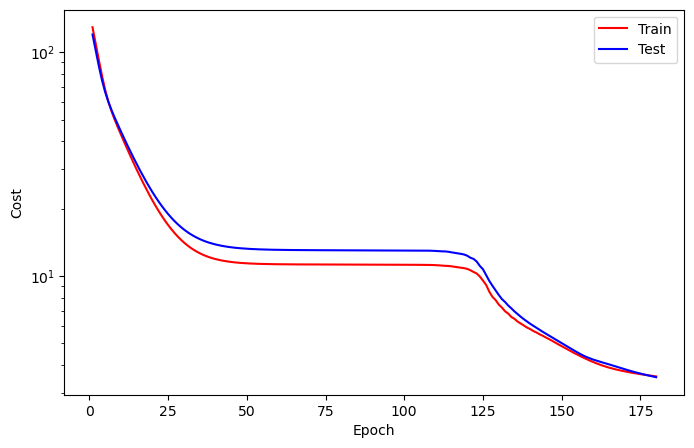

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   181
Train_cost  = 3.5395 | Test_cost  = 3.5002 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   182
Train_cost  = 3.5249 | Test_cost  = 3.4773 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   183
Train_cost  = 3.5106 | Test_cost  = 3.4558 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   184
Train_cost  = 3.4965 | Test_cost  = 3.4355 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   185
Train_cost  = 3.4826 | Test_cost  = 3.4167 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   186
Train_cost  = 3.4689 | Test_cost  = 3.3993 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   187
Train_cost  = 3.4553 | Test_cost  = 3.3832 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   188
Train_cost  = 3.4416 | Test_cost  = 3.3688 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   189
Train_cost  = 3.4278 | Test_cost  = 3.3565 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   190
Train_cost  = 3.4139 | Test_cost  = 3.3470 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   191
Train_cost  = 3.4000 | Test_cost  = 3.3397 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   192
Train_cost  = 3.3868 | Test_cost  = 3.3332 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   193
Train_cost  = 3.3744 | Test_cost  = 3.3254 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   194
Train_cost  = 3.3627 | Test_cost  = 3.3161 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   195
Train_cost  = 3.3515 | Test_cost  = 3.3064 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   196
Train_cost  = 3.3405 | Test_cost  = 3.2975 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   197
Train_cost  = 3.3296 | Test_cost  = 3.2894 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   198
Train_cost  = 3.3190 | Test_cost  = 3.2816 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   199
Train_cost  = 3.3085 | Test_cost  = 3.2733 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   200
Train_cost  = 3.2984 | Test_cost  = 3.2644 | 


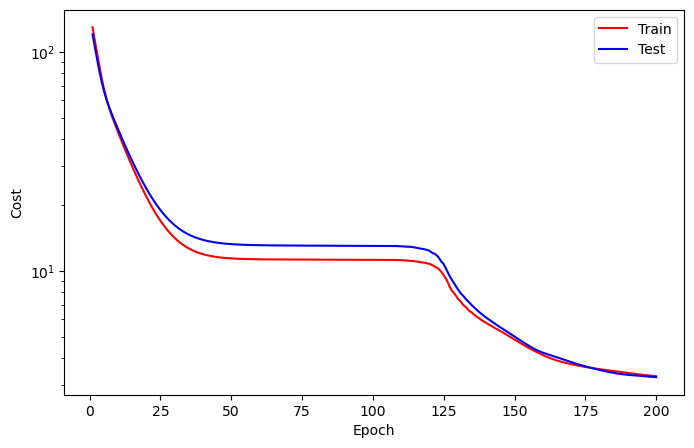

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   201
Train_cost  = 3.2886 | Test_cost  = 3.2547 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   202
Train_cost  = 3.2792 | Test_cost  = 3.2445 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   203
Train_cost  = 3.2701 | Test_cost  = 3.2342 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   204
Train_cost  = 3.2615 | Test_cost  = 3.2233 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   205
Train_cost  = 3.2535 | Test_cost  = 3.2118 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   206
Train_cost  = 3.2459 | Test_cost  = 3.1995 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   207
Train_cost  = 3.2386 | Test_cost  = 3.1863 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   208
Train_cost  = 3.2313 | Test_cost  = 3.1726 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   209
Train_cost  = 3.2238 | Test_cost  = 3.1589 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   210
Train_cost  = 3.2161 | Test_cost  = 3.1456 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   211
Train_cost  = 3.2084 | Test_cost  = 3.1331 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   212
Train_cost  = 3.2008 | Test_cost  = 3.1214 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   213
Train_cost  = 3.1934 | Test_cost  = 3.1104 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   214
Train_cost  = 3.1862 | Test_cost  = 3.1003 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   215
Train_cost  = 3.1789 | Test_cost  = 3.0910 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   216
Train_cost  = 3.1715 | Test_cost  = 3.0826 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   217
Train_cost  = 3.1643 | Test_cost  = 3.0749 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   218
Train_cost  = 3.1575 | Test_cost  = 3.0677 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   219
Train_cost  = 3.1511 | Test_cost  = 3.0606 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   220
Train_cost  = 3.1447 | Test_cost  = 3.0539 | 


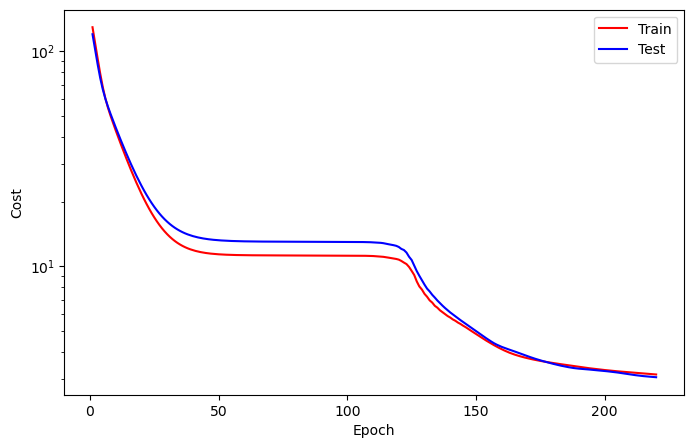

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   221
Train_cost  = 3.1383 | Test_cost  = 3.0477 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   222
Train_cost  = 3.1316 | Test_cost  = 3.0421 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   223
Train_cost  = 3.1251 | Test_cost  = 3.0369 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   224
Train_cost  = 3.1192 | Test_cost  = 3.0316 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   225
Train_cost  = 3.1138 | Test_cost  = 3.0260 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   226
Train_cost  = 3.1088 | Test_cost  = 3.0201 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   227
Train_cost  = 3.1035 | Test_cost  = 3.0146 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   228
Train_cost  = 3.0974 | Test_cost  = 3.0103 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   229
Train_cost  = 3.0906 | Test_cost  = 3.0072 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   230
Train_cost  = 3.0838 | Test_cost  = 3.0047 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   231
Train_cost  = 3.0777 | Test_cost  = 3.0015 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   232
Train_cost  = 3.0731 | Test_cost  = 2.9964 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   233
Train_cost  = 3.0701 | Test_cost  = 2.9888 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   234
Train_cost  = 3.0692 | Test_cost  = 2.9790 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   235
Train_cost  = 3.0716 | Test_cost  = 2.9674 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   236
Train_cost  = 3.0811 | Test_cost  = 2.9529 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   237
Train_cost  = 3.0982 | Test_cost  = 2.9293 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   238
Train_cost  = 3.0933 | Test_cost  = 2.9367 | 
==> EarlyStop patience =  1 | Best test_cost: 2.9293


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   239
Train_cost  = 3.0517 | Test_cost  = 3.0174 | 
==> EarlyStop patience =  2 | Best test_cost: 2.9293


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   240
Train_cost  = 3.0592 | Test_cost  = 3.0287 | 


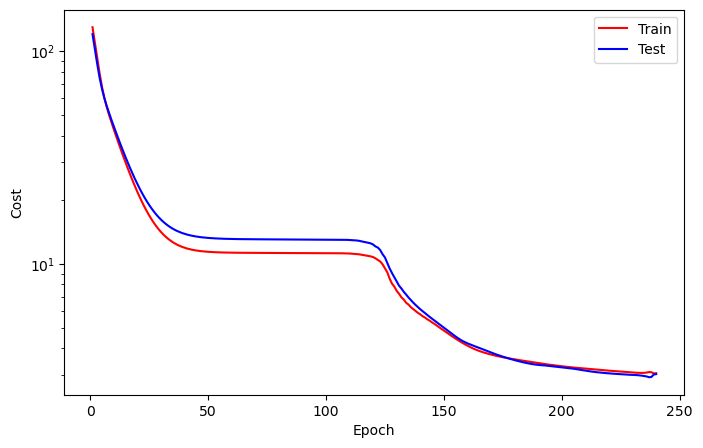

==> EarlyStop patience =  3 | Best test_cost: 2.9293


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   241
Train_cost  = 3.0806 | Test_cost  = 3.0347 | 
==> EarlyStop patience =  4 | Best test_cost: 2.9293


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   242
Train_cost  = 3.1000 | Test_cost  = 3.0847 | 
==> EarlyStop patience =  5 | Best test_cost: 2.9293
==> Execute Early Stopping at epoch: 242 | Best test_cost: 2.9293
==> Best model is saved at model/rnn


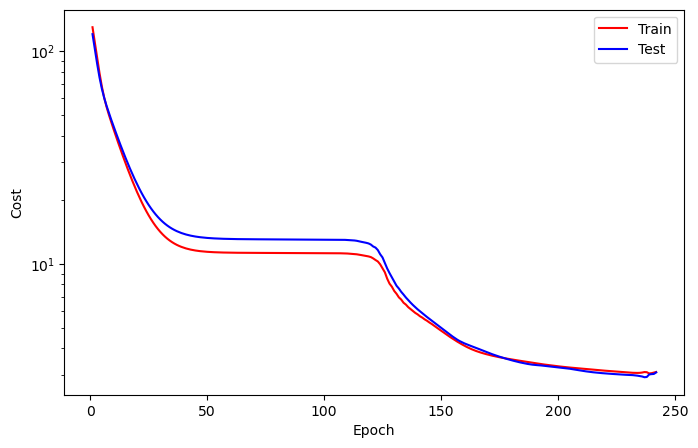

In [44]:
while True:
    train_cost = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)

    with torch.no_grad():
        test_cost = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor='test_cost'):
        callback.plot_cost()
        break



# Forecast

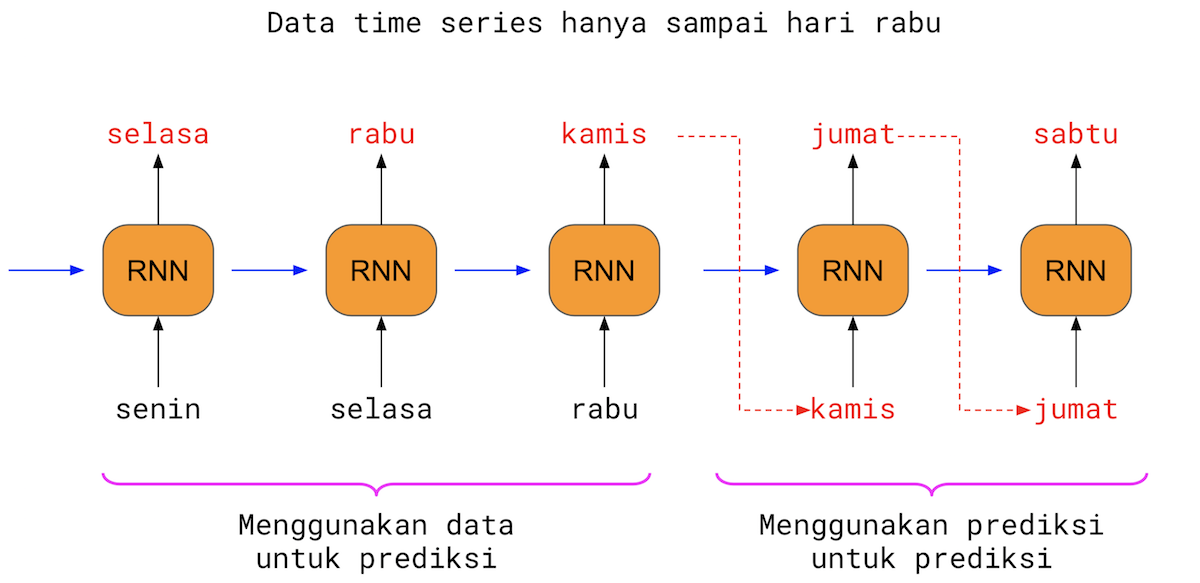

In [45]:
from luwiji.rnn import illustration

illustration.forecast

In [46]:
from utils import data4pred, pred4pred

train_forecast_set = TimeSeriesDataset(ts_train, 'Temp', 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, 'Temp', 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (417, 1, 1)
Note: last 0 data excluded

(N, S, F): (104, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

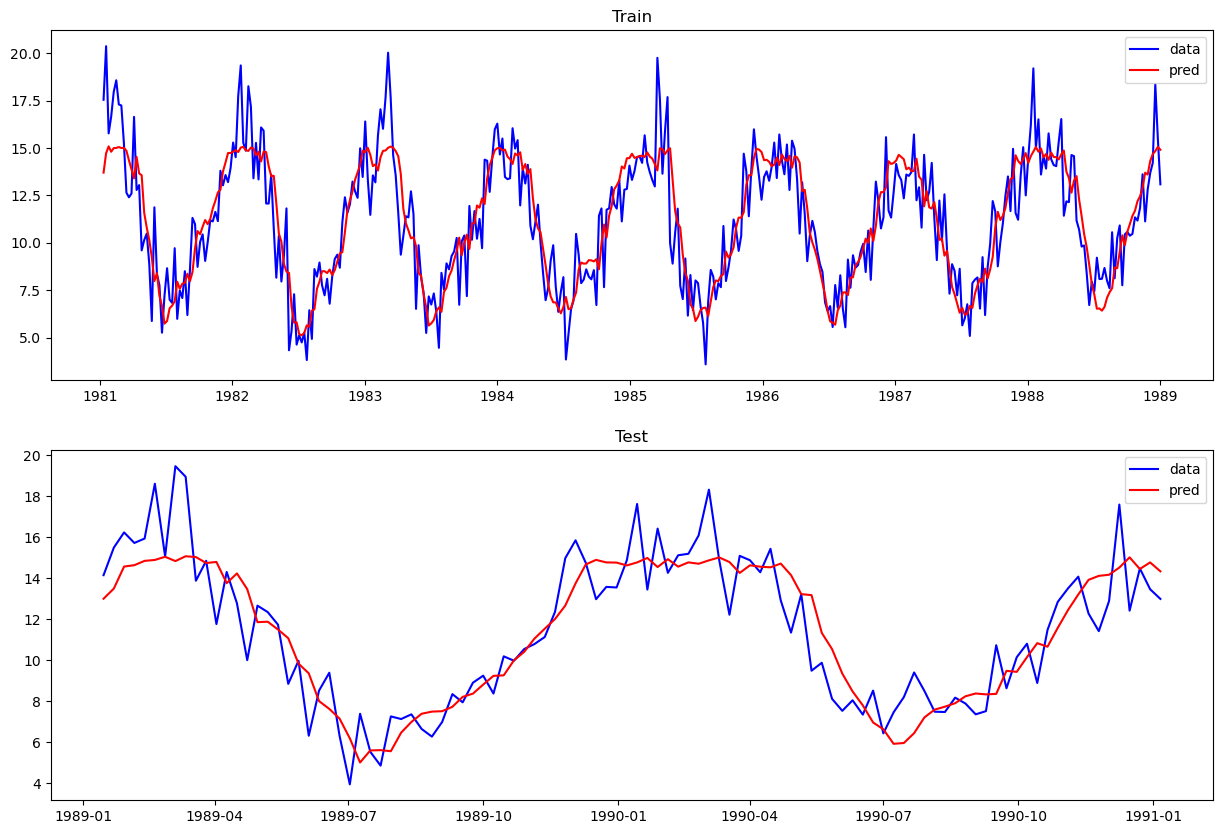

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title('Train')

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

Text(0.5, 1.0, 'Test')

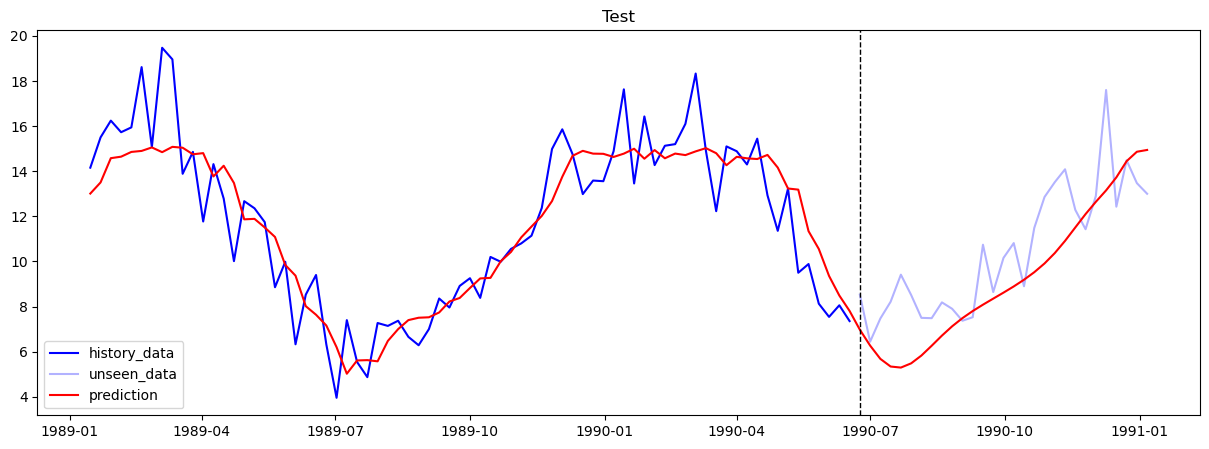

In [48]:
plt.figure(figsize=(15, 5))

pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

Text(0.5, 1.0, 'Test')

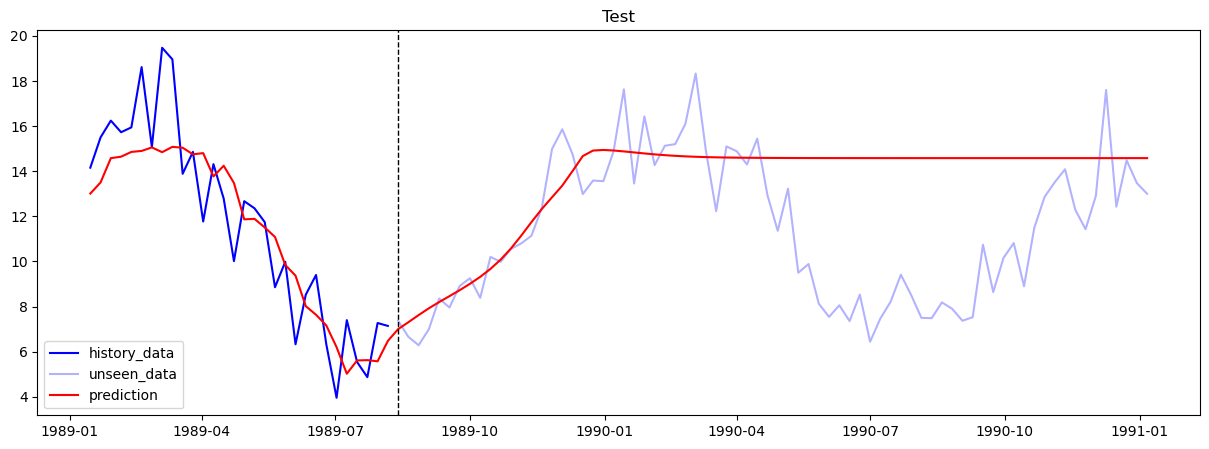

In [54]:
plt.figure(figsize=(15, 5))

pred4pred(model, test_forecast_set, testforecastloader, device, n_prior=30, n_forecast=110)
plt.title('Test')